In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

In [11]:
# Load and preprocess the data
df = pd.read_csv("C:/Users/trant/OneDrive/Tài liệu/Đồ án Phân tích dữ liệu/DATASET/BID.VN-1.csv")

In [12]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

# Extract close prices
prices = df['Close'].values

# Number of observations
num_obs = len(prices)



In [13]:
# Kalman Filter parameters
A = np.array([[1]])  # State transition matrix
H = np.array([[1]])  # Observation matrix
Q = np.array([[0.001]])  # Process noise covariance (adjusted)
R = np.array([[0.01]])  # Observation noise covariance (adjusted)

In [14]:
# Initial state and covariance
initial_state = np.array([prices[0]])  # Initial state
initial_covariance = np.array([[1]])  # Initial covariance

# Initialize state and covariance
state_estimate = initial_state
cov_estimate = initial_covariance

# Initialize lists to store predictions
predictions = []
future_predictions_30_days = []
future_predictions_60_days = []
future_predictions_90_days = []

# Kalman Filter predictions and updates
for i in range(num_obs):
    # Predict
    predicted_state = A.dot(state_estimate)
    predicted_covariance = A.dot(cov_estimate).dot(A.T) + Q
    
    # Update
    innovation = prices[i] - H.dot(predicted_state)
    innovation_covariance = H.dot(predicted_covariance).dot(H.T) + R
    kalman_gain = predicted_covariance.dot(H.T).dot(np.linalg.inv(innovation_covariance))
    state_estimate = predicted_state + kalman_gain * innovation
    cov_estimate = (np.eye(len(state_estimate)) - kalman_gain.dot(H)).dot(predicted_covariance)
    
    # Save predictions
    predictions.append(state_estimate[0])
    
    # Predictions for the next 30, 60, and 90 days
    if i == num_obs - 1:
        # Predict next 30 days
        state_copy = state_estimate.copy()
        for j in range(30):
            predicted_state = A.dot(state_copy)
            state_copy = predicted_state
            future_predictions_30_days.append(predicted_state[0])
        
        # Predict next 60 days
        state_copy = state_estimate.copy()
        for j in range(60):
            predicted_state = A.dot(state_copy)
            state_copy = predicted_state
            future_predictions_60_days.append(predicted_state[0])
        
        # Predict next 90 days
        state_copy = state_estimate.copy()
        for j in range(90):
            predicted_state = A.dot(state_copy)
            state_copy = predicted_state
            future_predictions_90_days.append(predicted_state[0])

In [15]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30, 60, and 90 days
future_dates_30 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')
future_dates_60 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60, freq='D')
future_dates_90 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90, freq='D')

In [16]:
# Evaluate the accuracy of the test dataset
train_size = int(num_obs * 0.7)
test_data = prices[train_size:]
test_predictions = predictions[train_size:]

In [17]:
test_mape = mean_absolute_percentage_error(test_data, test_predictions)
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
test_msle = mean_squared_log_error(test_data, test_predictions)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSLE on Test dataset: {test_msle}")

MAPE on Test dataset: 0.013161998070195033
RMSE on Test dataset: 720.6466425463802
MSLE on Test dataset: 0.0003199011772542452


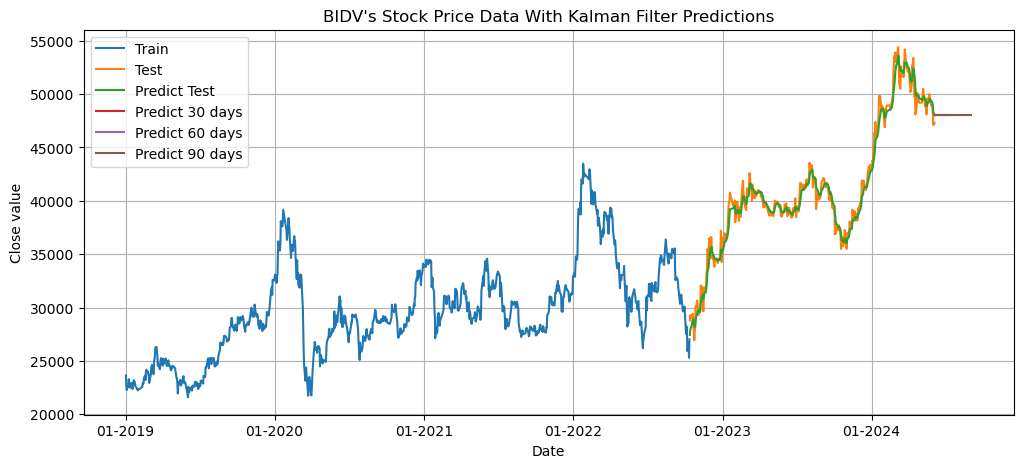

In [19]:
# Plotting
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df.index[:train_size], prices[:train_size], label='Train')

# Test set
plt.plot(df.index[train_size:], test_data, label='Test')

# Predictions in test set
plt.plot(df.index[train_size:], test_predictions, label='Predict Test')

# Predict 30 next days
plt.plot(future_dates_30, future_predictions_30_days, label='Predict 30 days')

# Predict 60 next days
plt.plot(future_dates_60, future_predictions_60_days, label='Predict 60 days')

# Predict 90 next days
plt.plot(future_dates_90, future_predictions_90_days, label='Predict 90 days')

plt.legend()
plt.grid()
plt.title("BIDV's Stock Price Data With Kalman Filter Predictions")
plt.xlabel("Date")
plt.ylabel("Close value")

# Set date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

plt.show()